In [1]:
library(rpart)
library(rpart.plot)
library(pROC)

# Define the directory structure using file.path()
my_dir <- file.path("C:/Users/GPEL_HPENVY/Desktop/Project_Predictive_Analytics_R")

# Check if the directory exists
if (dir.exists(my_dir)) {
  # Set the working directory
  setwd(my_dir)
  cat("Working directory set to:", getwd(), "\n")
} else {
  cat("Directory does not exist:", my_dir, "\n")
}

Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



Working directory set to: C:/Users/GPEL_HPENVY/Desktop/Project_Predictive_Analytics_R 


In [2]:
# set file path
# read csv file
#setwd('H:/GPEL_HPENVY/Documents/UNSW/07_ZZBU6511/Assessment3/')
employees <- read.csv(file = 'employees2.csv')

# Modify the column names to remove unwanted characters (assuming the problematic column is named "ï..Age")
colnames(employees) <- gsub("ï\\.{2}", "", colnames(employees))

In [3]:
# Inspect file
head(employees)


Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,HighPerformance
26,No,Travel_Frequently,Research & Development,10,3,3,Male,4,Laboratory Technician,...,1,1,8,3,3,7,7,7,7,0
33,No,Travel_Rarely,Research & Development,13,5,4,Male,3,Healthcare Representative,...,1,0,14,6,3,0,0,0,0,0
59,No,Travel_Rarely,Research & Development,5,3,3,Female,4,Laboratory Technician,...,1,3,12,3,2,1,0,0,0,1
42,No,Travel_Rarely,Research & Development,21,3,2,Male,4,Healthcare Representative,...,3,2,10,2,2,0,0,0,0,0
24,No,Travel_Rarely,Research & Development,27,1,4,Female,2,Manufacturing Director,...,2,2,5,6,3,4,2,3,2,0
29,No,Travel_Rarely,Research & Development,37,2,3,Male,4,Research Scientist,...,3,1,10,3,3,10,7,0,7,1


In [4]:
employees$Over18 = NULL # don't use this column

In [5]:
# Split the data to training and testing
set.seed(57)
rows <- sample(nrow(employees), 0.8*nrow(employees))
training <- employees[rows, ]
testing <- employees[-rows, ]

n= 800 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 800 121 No (0.84875000 0.15125000)  
   2) OverTime=No 584  57 No (0.90239726 0.09760274)  
     4) Age>=21.5 571  49 No (0.91418564 0.08581436) *
     5) Age< 21.5 13   5 Yes (0.38461538 0.61538462) *
   3) OverTime=Yes 216  64 No (0.70370370 0.29629630)  
     6) JobRole=Healthcare Representative,Manager,Manufacturing Director,Research Director,Research Scientist 119  19 No (0.84033613 0.15966387)  
      12) MonthlyIncome>=3514 90   9 No (0.90000000 0.10000000) *
      13) MonthlyIncome< 3514 29  10 No (0.65517241 0.34482759)  
        26) YearsWithCurrManager>=0.5 21   4 No (0.80952381 0.19047619) *
        27) YearsWithCurrManager< 0.5 8   2 Yes (0.25000000 0.75000000) *
     7) JobRole=Human Resources,Laboratory Technician,Sales Executive,Sales Representative 97  45 No (0.53608247 0.46391753)  
      14) DistanceFromHome< 17.5 66  23 No (0.65151515 0.34848485)  
        28) StockOptionLevel>=0.5

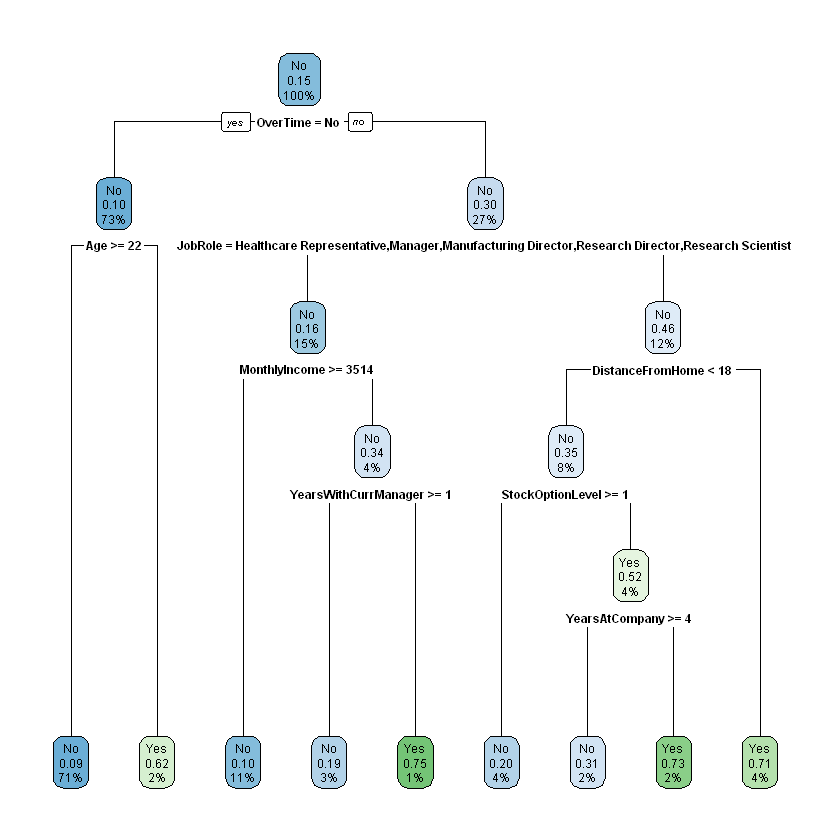

In [6]:
# Making the predictions. 
tree <- rpart(
  formula = Attrition ~ . - Attrition,
  data = training,
  method = "class"
)
rpart.plot(tree)
tree

In [7]:
# Apply it to the training data
training$Prediction <- predict(
  object = tree,
  newdata = training, type = "prob"
)
training$Prediction <- ifelse(
  training$Prediction[ , 2] >= 0.145, 1, 0
)
emp_train_roc <- roc(
  training$Attrition ~ training$Prediction,
  auc = TRUE
)
emp_train_roc

Setting levels: control = No, case = Yes
Setting direction: controls < cases



Call:
roc.formula(formula = training$Attrition ~ training$Prediction,     auc = TRUE)

Data: training$Prediction in 679 controls (training$Attrition No) < 121 cases (training$Attrition Yes).
Area under the curve: 0.7044

   
     No Yes
  0 603  58
  1  76  63

Accuracy: 0.8325
Sensitivity: 0.520661157024793
Specificity: 0.888070692194403
Setting levels: control = No, case = Yes
Setting direction: controls < cases



Call:
roc.formula(formula = testing$Attrition ~ testing$Prediction,     auc = TRUE)

Data: testing$Prediction in 171 controls (testing$Attrition No) < 29 cases (testing$Attrition Yes).
Area under the curve: 0.7083

   
     No Yes
  0 142  12
  1  29  17

Accuracy: 0.795
Sensitivity: 0.586206896551724
Specificity: 0.830409356725146


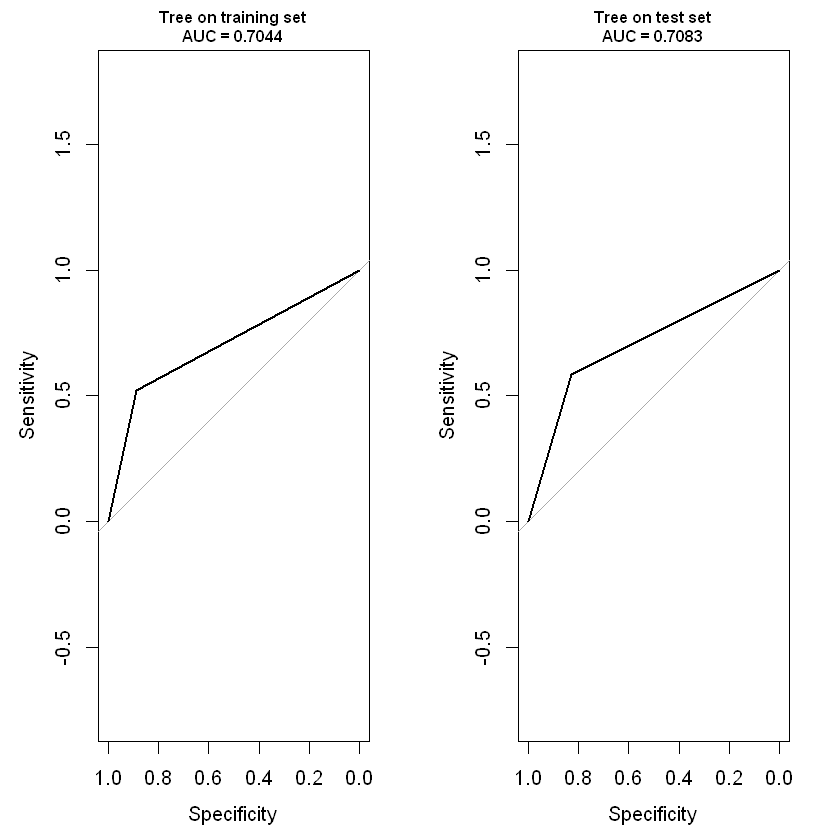

In [8]:
# Plot the ROC curves and show AUC
par(mfrow=c(1, 2), cex.main=0.8)
plot(
  emp_train_roc,
  main=paste("Tree on training set\nAUC =", round(emp_train_roc$auc, digits=4))
)
train_conf_matrix <- table(training$Prediction, training$Attrition)
train_conf_matrix
message("Accuracy: ", sum(diag(train_conf_matrix))/sum(train_conf_matrix))
message("Sensitivity: ", train_conf_matrix[2,2]/sum(train_conf_matrix[,2]))
message("Specificity: ", train_conf_matrix[1,1]/sum(train_conf_matrix[,1]))
testing$Prediction <- predict(
  tree,
  testing,
  type = "prob"
)
# Apply it to the testing data
testing$Prediction <- ifelse(
  testing$Prediction[ , 2] >= 0.145, 1, 0
)
emp_test_roc <- roc(
  testing$Attrition ~ testing$Prediction,
  auc = TRUE
)
emp_test_roc
# Plot the ROC curves and show AUC
plot(
  emp_test_roc,
  main=paste("Tree on test set\nAUC =", round(emp_test_roc$auc, digits=4))
)
test_conf_matrix <- table(testing$Prediction, testing$Attrition)
test_conf_matrix
message("Accuracy: ", sum(diag(test_conf_matrix))/sum(test_conf_matrix))
message("Sensitivity: ", test_conf_matrix[2,2]/sum(test_conf_matrix[,2]))
message("Specificity: ", test_conf_matrix[1,1]/sum(test_conf_matrix[,1]))